In [ ]:
!git clone https://github.com/Azfe38/project_image_recognition_CIFAR-10

Cloning into 'project_image_recognition_CIFAR-10'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 20 (delta 2), reused 0 (delta 0), pack-reused 14
Receiving objects: 100% (20/20), 162.17 MiB | 13.72 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (11/11), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  project_image_recognition_CIFAR-10/  sample_data/


In [ ]:
cd project_image_recognition_CIFAR-10/

/content/project_image_recognition_CIFAR-10


In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [ ]:
veri_isimleri = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [ ]:
all_data = [0,1,2,3,4,5,6]

In [ ]:
yol = 'cifar-10-batches-py/'

In [ ]:
for i,direc in zip(all_data,veri_isimleri):
    all_data[i] = unpickle(yol+direc)

In [ ]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [ ]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [ ]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [ ]:
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')

import numpy as np

In [ ]:
X = data_batch1[b"data"]

In [ ]:
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [ ]:
X[0].max()

255

In [ ]:
(X[0]/255).max()

1.0

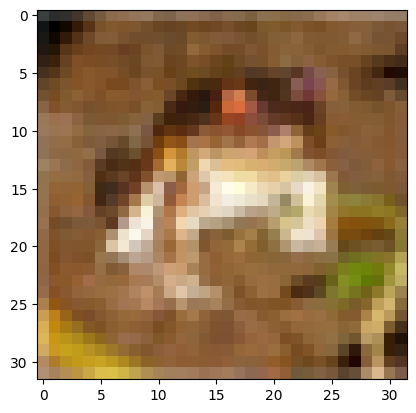

In [ ]:
plt.imshow(X[0])

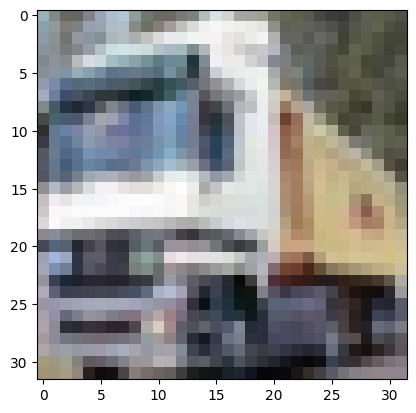

In [ ]:
plt.imshow(X[1])

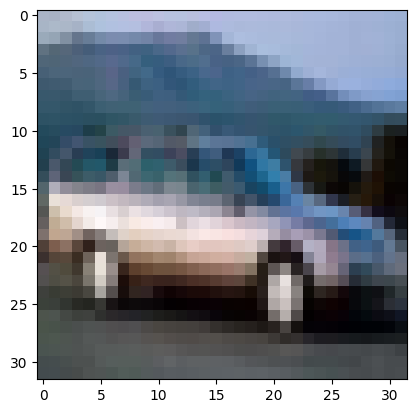

In [ ]:
plt.imshow(X[4])

In [ ]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [ ]:
class CifarHelper():

    def __init__(self):
        self.i = 0

        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]

        self.training_images = None
        self.training_labels = None

        self.test_images = None
        self.test_labels = None

    def set_up_images(self):

        print("Setting Up Training Images and Labels")

        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)

        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)

        print("Setting Up Test Images and Labels")

        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)

        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)


    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [ ]:
ch = CifarHelper()
ch.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,10])

In [ ]:
hold_prob = tf.placeholder(tf.float32)

In [ ]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [ ]:
convo_1 = convolutional_layer(x,shape=[4,4,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [ ]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [ ]:
convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])

In [ ]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [ ]:
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
y_pred = normal_full_layer(full_one_dropout,10)

In [ ]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [ ]:
init = tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(5001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.1035
Max acc =  0.1035


Adım 100
Model Dogrulugu = 
0.4148
Max acc =  0.4148


Adım 200
Model Dogrulugu = 
0.4585
Max acc =  0.4585


Adım 300
Model Dogrulugu = 
0.5042
Max acc =  0.5042


Adım 400
Model Dogrulugu = 
0.5115
Max acc =  0.5115


Adım 500
Model Dogrulugu = 
0.5355
Max acc =  0.5355


Adım 600
Model Dogrulugu = 
0.562
Max acc =  0.562


Adım 700
Model Dogrulugu = 
0.5689
Max acc =  0.5689


Adım 800
Model Dogrulugu = 
0.5776
Max acc =  0.5776


Adım 900
Model Dogrulugu = 
0.5977
Max acc =  0.5977


Adım 1000
Model Dogrulugu = 
0.6125
Max acc =  0.6125


Adım 1100
Model Dogrulugu = 
0.6269
Max acc =  0.6269


Adım 1200
Model Dogrulugu = 
0.6349
Max acc =  0.6349


Adım 1300
Model Dogrulugu = 
0.6278
Max acc =  0.6349


Adım 1400
Model Dogrulugu = 
0.6342
Max acc =  0.6349


Adım 1500
Model Dogrulugu = 
0.6478
Max acc =  0.6478


Adım 1600
Model Dogrulugu = 
0.649
Max acc =  0.649


Adım 1700
Model Dogrulugu = 
0.6644
Max acc =  0.6644


Adım 180

Optimizasyon parametrelerini ve Optimizasyon algoritmalarını değitiriyoruz.

In [ ]:
optimizer_2 = tf.train.AdadeltaOptimizer(learning_rate=0.001)
train = optimizer_2.minimize(cross_entropy)

In [ ]:
init = tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(5001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.0796
Max acc =  0.0796


Adım 100
Model Dogrulugu = 
0.0851
Max acc =  0.0851


Adım 200
Model Dogrulugu = 
0.0915
Max acc =  0.0915


Adım 300
Model Dogrulugu = 
0.0956
Max acc =  0.0956


Adım 400
Model Dogrulugu = 
0.1005
Max acc =  0.1005


Adım 500
Model Dogrulugu = 
0.1044
Max acc =  0.1044


Adım 600
Model Dogrulugu = 
0.1066
Max acc =  0.1066


Adım 700
Model Dogrulugu = 
0.108
Max acc =  0.108


Adım 800
Model Dogrulugu = 
0.1107
Max acc =  0.1107


Adım 900
Model Dogrulugu = 
0.1118
Max acc =  0.1118


Adım 1000
Model Dogrulugu = 
0.1136
Max acc =  0.1136


Adım 1100
Model Dogrulugu = 
0.1163
Max acc =  0.1163


Adım 1200
Model Dogrulugu = 
0.1199
Max acc =  0.1199


Adım 1300
Model Dogrulugu = 
0.121
Max acc =  0.121


Adım 1400
Model Dogrulugu = 
0.123
Max acc =  0.123


Adım 1500
Model Dogrulugu = 
0.1257
Max acc =  0.1257


Adım 1600
Model Dogrulugu = 
0.1282
Max acc =  0.1282


Adım 1700
Model Dogrulugu = 
0.1278
Max acc =  0.1282


Adım 1800


In [ ]:
optimizer_3 = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer_3.minimize(cross_entropy)

In [ ]:
init = tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(5001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.0838
Max acc =  0.0838


Adım 100
Model Dogrulugu = 
0.1436
Max acc =  0.1436


Adım 200
Model Dogrulugu = 
0.1733
Max acc =  0.1733


Adım 300
Model Dogrulugu = 
0.1946
Max acc =  0.1946


Adım 400
Model Dogrulugu = 
0.2116
Max acc =  0.2116


Adım 500
Model Dogrulugu = 
0.2168
Max acc =  0.2168


Adım 600
Model Dogrulugu = 
0.228
Max acc =  0.228


Adım 700
Model Dogrulugu = 
0.2347
Max acc =  0.2347


Adım 800
Model Dogrulugu = 
0.2353
Max acc =  0.2353


Adım 900
Model Dogrulugu = 
0.2459
Max acc =  0.2459


Adım 1000
Model Dogrulugu = 
0.2523
Max acc =  0.2523


Adım 1100
Model Dogrulugu = 
0.2644
Max acc =  0.2644


Adım 1200
Model Dogrulugu = 
0.2653
Max acc =  0.2653


Adım 1300
Model Dogrulugu = 
0.2681
Max acc =  0.2681


Adım 1400
Model Dogrulugu = 
0.2766
Max acc =  0.2766


Adım 1500
Model Dogrulugu = 
0.2848
Max acc =  0.2848


Adım 1600
Model Dogrulugu = 
0.2896
Max acc =  0.2896


Adım 1700
Model Dogrulugu = 
0.2926
Max acc =  0.2926


Adım 1

In [ ]:
optimizer_4 = tf.train.AdamOptimizer(learning_rate=0.005)
train = optimizer_4.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(5001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.1004
Max acc =  0.1004


Adım 100
Model Dogrulugu = 
0.3078
Max acc =  0.3078


Adım 200
Model Dogrulugu = 
0.3603
Max acc =  0.3603


Adım 300
Model Dogrulugu = 
0.359
Max acc =  0.3603


Adım 400
Model Dogrulugu = 
0.3926
Max acc =  0.3926


Adım 500
Model Dogrulugu = 
0.4115
Max acc =  0.4115


Adım 600
Model Dogrulugu = 
0.4156
Max acc =  0.4156


Adım 700
Model Dogrulugu = 
0.4122
Max acc =  0.4156


Adım 800
Model Dogrulugu = 
0.4309
Max acc =  0.4309


Adım 900
Model Dogrulugu = 
0.438
Max acc =  0.438


Adım 1000
Model Dogrulugu = 
0.4644
Max acc =  0.4644


Adım 1100
Model Dogrulugu = 
0.4484
Max acc =  0.4644


Adım 1200
Model Dogrulugu = 
0.4549
Max acc =  0.4644


Adım 1300
Model Dogrulugu = 
0.4771
Max acc =  0.4771


Adım 1400
Model Dogrulugu = 
0.4752
Max acc =  0.4771


Adım 1500
Model Dogrulugu = 
0.4623
Max acc =  0.4771


Adım 1600
Model Dogrulugu = 
0.478
Max acc =  0.478


Adım 1700
Model Dogrulugu = 
0.4809
Max acc =  0.4809


Adım 1800

In [ ]:
optimizer_5 = tf.train.AdadeltaOptimizer(learning_rate=0.005)
train = optimizer_5.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(5001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.143
Max acc =  0.143


Adım 100
Model Dogrulugu = 
0.1369
Max acc =  0.143


Adım 200
Model Dogrulugu = 
0.1317
Max acc =  0.143


Adım 300
Model Dogrulugu = 
0.1317
Max acc =  0.143


Adım 400
Model Dogrulugu = 
0.1463
Max acc =  0.1463


Adım 500
Model Dogrulugu = 
0.1503
Max acc =  0.1503


Adım 600
Model Dogrulugu = 
0.1619
Max acc =  0.1619


Adım 700
Model Dogrulugu = 
0.1675
Max acc =  0.1675


Adım 800
Model Dogrulugu = 
0.1778
Max acc =  0.1778


Adım 900
Model Dogrulugu = 
0.1875
Max acc =  0.1875


Adım 1000
Model Dogrulugu = 
0.198
Max acc =  0.198


Adım 1100
Model Dogrulugu = 
0.2064
Max acc =  0.2064


Adım 1200
Model Dogrulugu = 
0.2095
Max acc =  0.2095


Adım 1300
Model Dogrulugu = 
0.2178
Max acc =  0.2178


Adım 1400
Model Dogrulugu = 
0.2256
Max acc =  0.2256


Adım 1500
Model Dogrulugu = 
0.2324
Max acc =  0.2324


Adım 1600
Model Dogrulugu = 
0.2406
Max acc =  0.2406


Adım 1700
Model Dogrulugu = 
0.2432
Max acc =  0.2432


Adım 1800
M

In [ ]:
optimizer_6 = tf.train.GradientDescentOptimizer(learning_rate=0.005)
train = optimizer_6.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(5001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.1016
Max acc =  0.1016


Adım 100
Model Dogrulugu = 
0.2076
Max acc =  0.2076


Adım 200
Model Dogrulugu = 
0.2455
Max acc =  0.2455


Adım 300
Model Dogrulugu = 
0.278
Max acc =  0.278


Adım 400
Model Dogrulugu = 
0.2832
Max acc =  0.2832


Adım 500
Model Dogrulugu = 
0.3183
Max acc =  0.3183


Adım 600
Model Dogrulugu = 
0.3189
Max acc =  0.3189


Adım 700
Model Dogrulugu = 
0.3473
Max acc =  0.3473


Adım 800
Model Dogrulugu = 
0.3291
Max acc =  0.3473


Adım 900
Model Dogrulugu = 
0.3616
Max acc =  0.3616


Adım 1000
Model Dogrulugu = 
0.3723
Max acc =  0.3723


Adım 1100
Model Dogrulugu = 
0.3593
Max acc =  0.3723


Adım 1200
Model Dogrulugu = 
0.3757
Max acc =  0.3757


Adım 1300
Model Dogrulugu = 
0.387
Max acc =  0.387


Adım 1400
Model Dogrulugu = 
0.396
Max acc =  0.396


Adım 1500
Model Dogrulugu = 
0.3992
Max acc =  0.3992


Adım 1600
Model Dogrulugu = 
0.3835
Max acc =  0.3992


Adım 1700
Model Dogrulugu = 
0.4054
Max acc =  0.4054


Adım 1800


In [ ]:
optimizer_7 = tf.train.AdamOptimizer(learning_rate=0.01)
train = optimizer_7.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(5001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.1028
Max acc =  0.1028


Adım 100
Model Dogrulugu = 
0.1
Max acc =  0.1028


Adım 200
Model Dogrulugu = 
0.1
Max acc =  0.1028


Adım 300
Model Dogrulugu = 
0.1
Max acc =  0.1028


Adım 400
Model Dogrulugu = 
0.1
Max acc =  0.1028


Adım 500
Model Dogrulugu = 
0.1
Max acc =  0.1028


Adım 600
Model Dogrulugu = 
0.1
Max acc =  0.1028


Adım 700
Model Dogrulugu = 
0.1
Max acc =  0.1028


Adım 800
Model Dogrulugu = 
0.1
Max acc =  0.1028


Adım 900
Model Dogrulugu = 
0.1
Max acc =  0.1028


Adım 1000
Model Dogrulugu = 
0.1
Max acc =  0.1028


Adım 1100
Model Dogrulugu = 
0.1
Max acc =  0.1028


Adım 1200
Model Dogrulugu = 
0.1
Max acc =  0.1028


Adım 1300
Model Dogrulugu = 
0.1
Max acc =  0.1028


Adım 1400
Model Dogrulugu = 
0.1
Max acc =  0.1028


Adım 1500
Model Dogrulugu = 
0.1
Max acc =  0.1028


Adım 1600
Model Dogrulugu = 
0.1
Max acc =  0.1028


Adım 1700
Model Dogrulugu = 
0.1
Max acc =  0.1028


Adım 1800
Model Dogrulugu = 
0.1
Max acc =  0.1028


Ad

In [ ]:
optimizer_8 = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer_8.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(5001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.1001
Max acc =  0.1001


Adım 100
Model Dogrulugu = 
0.3127
Max acc =  0.3127


Adım 200
Model Dogrulugu = 
0.3658
Max acc =  0.3658


Adım 300
Model Dogrulugu = 
0.3912
Max acc =  0.3912


Adım 400
Model Dogrulugu = 
0.4137
Max acc =  0.4137


Adım 500
Model Dogrulugu = 
0.4329
Max acc =  0.4329


Adım 600
Model Dogrulugu = 
0.4423
Max acc =  0.4423


Adım 700
Model Dogrulugu = 
0.4483
Max acc =  0.4483


Adım 800
Model Dogrulugu = 
0.462
Max acc =  0.462


Adım 900
Model Dogrulugu = 
0.4743
Max acc =  0.4743


Adım 1000
Model Dogrulugu = 
0.4777
Max acc =  0.4777


Adım 1100
Model Dogrulugu = 
0.4915
Max acc =  0.4915


Adım 1200
Model Dogrulugu = 
0.5007
Max acc =  0.5007


Adım 1300
Model Dogrulugu = 
0.5039
Max acc =  0.5039


Adım 1400
Model Dogrulugu = 
0.5123
Max acc =  0.5123


Adım 1500
Model Dogrulugu = 
0.5124
Max acc =  0.5124


Adım 1600
Model Dogrulugu = 
0.5222
Max acc =  0.5222


Adım 1700
Model Dogrulugu = 
0.5239
Max acc =  0.5239


Adım 1

In [ ]:
optimizer_9 = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer_9.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(10001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.0866
Max acc =  0.0866


Adım 100
Model Dogrulugu = 
0.3302
Max acc =  0.3302


Adım 200
Model Dogrulugu = 
0.3852
Max acc =  0.3852


Adım 300
Model Dogrulugu = 
0.4104
Max acc =  0.4104


Adım 400
Model Dogrulugu = 
0.4338
Max acc =  0.4338


Adım 500
Model Dogrulugu = 
0.4481
Max acc =  0.4481


Adım 600
Model Dogrulugu = 
0.4604
Max acc =  0.4604


Adım 700
Model Dogrulugu = 
0.4707
Max acc =  0.4707


Adım 800
Model Dogrulugu = 
0.4767
Max acc =  0.4767


Adım 900
Model Dogrulugu = 
0.4922
Max acc =  0.4922


Adım 1000
Model Dogrulugu = 
0.4947
Max acc =  0.4947


Adım 1100
Model Dogrulugu = 
0.5073
Max acc =  0.5073


Adım 1200
Model Dogrulugu = 
0.5168
Max acc =  0.5168


Adım 1300
Model Dogrulugu = 
0.5185
Max acc =  0.5185


Adım 1400
Model Dogrulugu = 
0.5303
Max acc =  0.5303


Adım 1500
Model Dogrulugu = 
0.533
Max acc =  0.533


Adım 1600
Model Dogrulugu = 
0.5379
Max acc =  0.5379


Adım 1700
Model Dogrulugu = 
0.5469
Max acc =  0.5469


Adım 1

In [ ]:
optimizer_10 = tf.train.AdamOptimizer(learning_rate=0.1)
train = optimizer_10.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(5001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 100
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 200
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 300
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 400
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 500
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 600
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 700
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 800
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 900
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1000
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1100
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1200
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1300
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1400
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1500
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1600
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1700
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1800
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1900
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 2000
Mo

In [ ]:
optimizer_11 = tf.train.AdadeltaOptimizer(learning_rate=0.0001)
train = optimizer_11.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(10001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.0723
Max acc =  0.0723


Adım 100
Model Dogrulugu = 
0.0718
Max acc =  0.0723


Adım 200
Model Dogrulugu = 
0.0721
Max acc =  0.0723


Adım 300
Model Dogrulugu = 
0.0726
Max acc =  0.0726


Adım 400
Model Dogrulugu = 
0.072
Max acc =  0.0726


Adım 500
Model Dogrulugu = 
0.0719
Max acc =  0.0726


Adım 600
Model Dogrulugu = 
0.0723
Max acc =  0.0726


Adım 700
Model Dogrulugu = 
0.0722
Max acc =  0.0726


Adım 800
Model Dogrulugu = 
0.0723
Max acc =  0.0726


Adım 900
Model Dogrulugu = 
0.0724
Max acc =  0.0726


Adım 1000
Model Dogrulugu = 
0.0731
Max acc =  0.0731


Adım 1100
Model Dogrulugu = 
0.0738
Max acc =  0.0738


Adım 1200
Model Dogrulugu = 
0.0741
Max acc =  0.0741


Adım 1300
Model Dogrulugu = 
0.0751
Max acc =  0.0751


Adım 1400
Model Dogrulugu = 
0.0747
Max acc =  0.0751


Adım 1500
Model Dogrulugu = 
0.0754
Max acc =  0.0754


Adım 1600
Model Dogrulugu = 
0.0755
Max acc =  0.0755


Adım 1700
Model Dogrulugu = 
0.0762
Max acc =  0.0762


Adım 

In [ ]:
optimizer_12 = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
train = optimizer_12.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(10001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.1043
Max acc =  0.1043


Adım 100
Model Dogrulugu = 
0.1066
Max acc =  0.1066


Adım 200
Model Dogrulugu = 
0.1241
Max acc =  0.1241


Adım 300
Model Dogrulugu = 
0.1338
Max acc =  0.1338


Adım 400
Model Dogrulugu = 
0.1463
Max acc =  0.1463


Adım 500
Model Dogrulugu = 
0.1548
Max acc =  0.1548


Adım 600
Model Dogrulugu = 
0.1632
Max acc =  0.1632


Adım 700
Model Dogrulugu = 
0.1656
Max acc =  0.1656


Adım 800
Model Dogrulugu = 
0.1701
Max acc =  0.1701


Adım 900
Model Dogrulugu = 
0.1711
Max acc =  0.1711


Adım 1000
Model Dogrulugu = 
0.1717
Max acc =  0.1717


Adım 1100
Model Dogrulugu = 
0.1764
Max acc =  0.1764


Adım 1200
Model Dogrulugu = 
0.1776
Max acc =  0.1776


Adım 1300
Model Dogrulugu = 
0.1794
Max acc =  0.1794


Adım 1400
Model Dogrulugu = 
0.179
Max acc =  0.1794


Adım 1500
Model Dogrulugu = 
0.1821
Max acc =  0.1821


Adım 1600
Model Dogrulugu = 
0.185
Max acc =  0.185


Adım 1700
Model Dogrulugu = 
0.1886
Max acc =  0.1886


Adım 18

1. bölüm

In [ ]:
optimizer_13 = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
train = optimizer_13.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(5001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.1001
Max acc =  0.1001


Adım 100
Model Dogrulugu = 
0.0957
Max acc =  0.1001


Adım 200
Model Dogrulugu = 
0.1091
Max acc =  0.1091


Adım 300
Model Dogrulugu = 
0.1094
Max acc =  0.1094


Adım 400
Model Dogrulugu = 
0.122
Max acc =  0.122


Adım 500
Model Dogrulugu = 
0.1306
Max acc =  0.1306


Adım 600
Model Dogrulugu = 
0.1354
Max acc =  0.1354


Adım 700
Model Dogrulugu = 
0.1378
Max acc =  0.1378


Adım 800
Model Dogrulugu = 
0.1414
Max acc =  0.1414


Adım 900
Model Dogrulugu = 
0.1454
Max acc =  0.1454


Adım 1000
Model Dogrulugu = 
0.1496
Max acc =  0.1496


Adım 1100
Model Dogrulugu = 
0.1529
Max acc =  0.1529


Adım 1200
Model Dogrulugu = 
0.1496
Max acc =  0.1529


Adım 1300
Model Dogrulugu = 
0.1547
Max acc =  0.1547


Adım 1400
Model Dogrulugu = 
0.1598
Max acc =  0.1598


Adım 1500
Model Dogrulugu = 
0.1576
Max acc =  0.1598


Adım 1600
Model Dogrulugu = 
0.1621
Max acc =  0.1621


Adım 1700
Model Dogrulugu = 
0.1622
Max acc =  0.1622


Adım 1

In [ ]:
optimizer_14 = tf.train.AdadeltaOptimizer(learning_rate=0.0001)
train = optimizer_14.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(5001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.1107
Max acc =  0.1107


Adım 100
Model Dogrulugu = 
0.1107
Max acc =  0.1107


Adım 200
Model Dogrulugu = 
0.1114
Max acc =  0.1114


Adım 300
Model Dogrulugu = 
0.1117
Max acc =  0.1117


Adım 400
Model Dogrulugu = 
0.1117
Max acc =  0.1117


Adım 500
Model Dogrulugu = 
0.1123
Max acc =  0.1123


Adım 600
Model Dogrulugu = 
0.1128
Max acc =  0.1128


Adım 700
Model Dogrulugu = 
0.1137
Max acc =  0.1137


Adım 800
Model Dogrulugu = 
0.1142
Max acc =  0.1142


Adım 900
Model Dogrulugu = 
0.1146
Max acc =  0.1146


Adım 1000
Model Dogrulugu = 
0.1145
Max acc =  0.1146


Adım 1100
Model Dogrulugu = 
0.1148
Max acc =  0.1148


Adım 1200
Model Dogrulugu = 
0.1151
Max acc =  0.1151


Adım 1300
Model Dogrulugu = 
0.1151
Max acc =  0.1151


Adım 1400
Model Dogrulugu = 
0.1159
Max acc =  0.1159


Adım 1500
Model Dogrulugu = 
0.1171
Max acc =  0.1171


Adım 1600
Model Dogrulugu = 
0.1171
Max acc =  0.1171


Adım 1700
Model Dogrulugu = 
0.1175
Max acc =  0.1175


Adım

In [ ]:
optimizer_15 = tf.train.AdadeltaOptimizer(learning_rate=0.1)
train = optimizer_15.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(5001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.1047
Max acc =  0.1047


Adım 100
Model Dogrulugu = 
0.2603
Max acc =  0.2603


Adım 200
Model Dogrulugu = 
0.3067
Max acc =  0.3067


Adım 300
Model Dogrulugu = 
0.3388
Max acc =  0.3388


Adım 400
Model Dogrulugu = 
0.3662
Max acc =  0.3662


Adım 500
Model Dogrulugu = 
0.3837
Max acc =  0.3837


Adım 600
Model Dogrulugu = 
0.3986
Max acc =  0.3986


Adım 700
Model Dogrulugu = 
0.4099
Max acc =  0.4099


Adım 800
Model Dogrulugu = 
0.4137
Max acc =  0.4137


Adım 900
Model Dogrulugu = 
0.4278
Max acc =  0.4278


Adım 1000
Model Dogrulugu = 
0.432
Max acc =  0.432


Adım 1100
Model Dogrulugu = 
0.4335
Max acc =  0.4335


Adım 1200
Model Dogrulugu = 
0.4492
Max acc =  0.4492


Adım 1300
Model Dogrulugu = 
0.4484
Max acc =  0.4492


Adım 1400
Model Dogrulugu = 
0.4532
Max acc =  0.4532


Adım 1500
Model Dogrulugu = 
0.4566
Max acc =  0.4566


Adım 1600
Model Dogrulugu = 
0.4645
Max acc =  0.4645


Adım 1700
Model Dogrulugu = 
0.4681
Max acc =  0.4681


Adım 1

In [ ]:
optimizer_16 = tf.train.AdadeltaOptimizer(learning_rate=0.01)
train = optimizer_16.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(5001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.1024
Max acc =  0.1024


Adım 100
Model Dogrulugu = 
0.1441
Max acc =  0.1441


Adım 200
Model Dogrulugu = 
0.1538
Max acc =  0.1538


Adım 300
Model Dogrulugu = 
0.1714
Max acc =  0.1714


Adım 400
Model Dogrulugu = 
0.1836
Max acc =  0.1836


Adım 500
Model Dogrulugu = 
0.1956
Max acc =  0.1956


Adım 600
Model Dogrulugu = 
0.2097
Max acc =  0.2097


Adım 700
Model Dogrulugu = 
0.2235
Max acc =  0.2235


Adım 800
Model Dogrulugu = 
0.234
Max acc =  0.234


Adım 900
Model Dogrulugu = 
0.2429
Max acc =  0.2429


Adım 1000
Model Dogrulugu = 
0.2506
Max acc =  0.2506


Adım 1100
Model Dogrulugu = 
0.2565
Max acc =  0.2565


Adım 1200
Model Dogrulugu = 
0.263
Max acc =  0.263


Adım 1300
Model Dogrulugu = 
0.2683
Max acc =  0.2683


Adım 1400
Model Dogrulugu = 
0.2735
Max acc =  0.2735


Adım 1500
Model Dogrulugu = 
0.2817
Max acc =  0.2817


Adım 1600
Model Dogrulugu = 
0.2883
Max acc =  0.2883


Adım 1700
Model Dogrulugu = 
0.2925
Max acc =  0.2925


Adım 180

In [ ]:
optimizer_17 = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train = optimizer_17.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(5001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.0956
Max acc =  0.0956


Adım 100
Model Dogrulugu = 
0.255
Max acc =  0.255


Adım 200
Model Dogrulugu = 
0.2436
Max acc =  0.255


Adım 300
Model Dogrulugu = 
0.3187
Max acc =  0.3187


Adım 400
Model Dogrulugu = 
0.3294
Max acc =  0.3294


Adım 500
Model Dogrulugu = 
0.3283
Max acc =  0.3294


Adım 600
Model Dogrulugu = 
0.3646
Max acc =  0.3646


Adım 700
Model Dogrulugu = 
0.3872
Max acc =  0.3872


Adım 800
Model Dogrulugu = 
0.3944
Max acc =  0.3944


Adım 900
Model Dogrulugu = 
0.3849
Max acc =  0.3944


Adım 1000
Model Dogrulugu = 
0.3907
Max acc =  0.3944


Adım 1100
Model Dogrulugu = 
0.3773
Max acc =  0.3944


Adım 1200
Model Dogrulugu = 
0.4258
Max acc =  0.4258


Adım 1300
Model Dogrulugu = 
0.4188
Max acc =  0.4258


Adım 1400
Model Dogrulugu = 
0.4375
Max acc =  0.4375


Adım 1500
Model Dogrulugu = 
0.4124
Max acc =  0.4375


Adım 1600
Model Dogrulugu = 
0.3814
Max acc =  0.4375


Adım 1700
Model Dogrulugu = 
0.4403
Max acc =  0.4403


Adım 18

In [ ]:
optimizer_18 = tf.train.GradientDescentOptimizer(learning_rate=0.1)
train = optimizer_18.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(5001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.112
Max acc =  0.112


Adım 100
Model Dogrulugu = 
0.1
Max acc =  0.112


Adım 200
Model Dogrulugu = 
0.1
Max acc =  0.112


Adım 300
Model Dogrulugu = 
0.1
Max acc =  0.112


Adım 400
Model Dogrulugu = 
0.0999
Max acc =  0.112


Adım 500
Model Dogrulugu = 
0.1
Max acc =  0.112


Adım 600
Model Dogrulugu = 
0.1
Max acc =  0.112


Adım 700
Model Dogrulugu = 
0.1
Max acc =  0.112


Adım 800
Model Dogrulugu = 
0.1001
Max acc =  0.112


Adım 900
Model Dogrulugu = 
0.1
Max acc =  0.112


Adım 1000
Model Dogrulugu = 
0.1
Max acc =  0.112


Adım 1100
Model Dogrulugu = 
0.1
Max acc =  0.112


Adım 1200
Model Dogrulugu = 
0.1
Max acc =  0.112


Adım 1300
Model Dogrulugu = 
0.1
Max acc =  0.112


Adım 1400
Model Dogrulugu = 
0.1
Max acc =  0.112


Adım 1500
Model Dogrulugu = 
0.1
Max acc =  0.112


Adım 1600
Model Dogrulugu = 
0.0995
Max acc =  0.112


Adım 1700
Model Dogrulugu = 
0.1
Max acc =  0.112


Adım 1800
Model Dogrulugu = 
0.0993
Max acc =  0.112


Adım 1900


In [ ]:
optimizer_19 = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer_19.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(10001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 100
Model Dogrulugu = 
0.3819
Max acc =  0.3819


Adım 200
Model Dogrulugu = 
0.4671
Max acc =  0.4671


Adım 300
Model Dogrulugu = 
0.4928
Max acc =  0.4928


Adım 400
Model Dogrulugu = 
0.5188
Max acc =  0.5188


Adım 500
Model Dogrulugu = 
0.5411
Max acc =  0.5411


Adım 600
Model Dogrulugu = 
0.5426
Max acc =  0.5426


Adım 700
Model Dogrulugu = 
0.5603
Max acc =  0.5603


Adım 800
Model Dogrulugu = 
0.5815
Max acc =  0.5815


Adım 900
Model Dogrulugu = 
0.5716
Max acc =  0.5815


Adım 1000
Model Dogrulugu = 
0.6101
Max acc =  0.6101


Adım 1100
Model Dogrulugu = 
0.6008
Max acc =  0.6101


Adım 1200
Model Dogrulugu = 
0.6159
Max acc =  0.6159


Adım 1300
Model Dogrulugu = 
0.6197
Max acc =  0.6197


Adım 1400
Model Dogrulugu = 
0.6207
Max acc =  0.6207


Adım 1500
Model Dogrulugu = 
0.6407
Max acc =  0.6407


Adım 1600
Model Dogrulugu = 
0.6422
Max acc =  0.6422


Adım 1700
Model Dogrulugu = 
0.6516
Max acc =  0.6516


Adım 1800


In [ ]:
optimizer_20 = tf.train.AdamOptimizer(learning_rate=0.01)
train = optimizer_20.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(10001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 100
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 200
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 300
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 400
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 500
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 600
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 700
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 800
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 900
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1000
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1100
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1200
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1300
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1400
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1500
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1600
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1700
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1800
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1900
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 2000
Mo

In [ ]:
optimizer_21 = tf.train.AdamOptimizer(learning_rate=0.1)
train = optimizer_21.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(10001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 100
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 200
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 300
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 400
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 500
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 600
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 700
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 800
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 900
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1000
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1100
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1200
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1300
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1400
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1500
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1600
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1700
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1800
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1900
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 2000
Mo

In [ ]:
optimizer_22 = tf.train.GradientDescentOptimizer(learning_rate=0.1)
train = optimizer_22.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(10001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 100
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 200
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 300
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 400
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 500
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 600
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 700
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 800
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 900
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1000
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1100
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1200
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1300
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1400
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1500
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1600
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1700
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1800
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 1900
Model Dogrulugu = 
0.1
Max acc =  0.1


Adım 2000
Mo

In [ ]:
optimizer_23 = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train = optimizer_23.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(10001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.1033
Max acc =  0.1033


Adım 100
Model Dogrulugu = 
0.2256
Max acc =  0.2256


Adım 200
Model Dogrulugu = 
0.2653
Max acc =  0.2653


Adım 300
Model Dogrulugu = 
0.2952
Max acc =  0.2952


Adım 400
Model Dogrulugu = 
0.2892
Max acc =  0.2952


Adım 500
Model Dogrulugu = 
0.3248
Max acc =  0.3248


Adım 600
Model Dogrulugu = 
0.3477
Max acc =  0.3477


Adım 700
Model Dogrulugu = 
0.3752
Max acc =  0.3752


Adım 800
Model Dogrulugu = 
0.3825
Max acc =  0.3825


Adım 900
Model Dogrulugu = 
0.3915
Max acc =  0.3915


Adım 1000
Model Dogrulugu = 
0.4045
Max acc =  0.4045


Adım 1100
Model Dogrulugu = 
0.408
Max acc =  0.408


Adım 1200
Model Dogrulugu = 
0.4153
Max acc =  0.4153


Adım 1300
Model Dogrulugu = 
0.4204
Max acc =  0.4204


Adım 1400
Model Dogrulugu = 
0.4166
Max acc =  0.4204


Adım 1500
Model Dogrulugu = 
0.4444
Max acc =  0.4444


Adım 1600
Model Dogrulugu = 
0.4274
Max acc =  0.4444


Adım 1700
Model Dogrulugu = 
0.4478
Max acc =  0.4478


Adım 1

In [ ]:
optimizer_24 = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer_24.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(10001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.0948
Max acc =  0.0948


Adım 100
Model Dogrulugu = 
0.1625
Max acc =  0.1625


Adım 200
Model Dogrulugu = 
0.1777
Max acc =  0.1777


Adım 300
Model Dogrulugu = 
0.1986
Max acc =  0.1986


Adım 400
Model Dogrulugu = 
0.2229
Max acc =  0.2229


Adım 500
Model Dogrulugu = 
0.2406
Max acc =  0.2406


Adım 600
Model Dogrulugu = 
0.2484
Max acc =  0.2484


Adım 700
Model Dogrulugu = 
0.2615
Max acc =  0.2615


Adım 800
Model Dogrulugu = 
0.2731
Max acc =  0.2731


Adım 900
Model Dogrulugu = 
0.2788
Max acc =  0.2788


Adım 1000
Model Dogrulugu = 
0.288
Max acc =  0.288


Adım 1100
Model Dogrulugu = 
0.2886
Max acc =  0.2886


Adım 1200
Model Dogrulugu = 
0.3013
Max acc =  0.3013


Adım 1300
Model Dogrulugu = 
0.3071
Max acc =  0.3071


Adım 1400
Model Dogrulugu = 
0.3093
Max acc =  0.3093


Adım 1500
Model Dogrulugu = 
0.3105
Max acc =  0.3105


Adım 1600
Model Dogrulugu = 
0.3179
Max acc =  0.3179


Adım 1700
Model Dogrulugu = 
0.3183
Max acc =  0.3183


Adım 1

In [ ]:
optimizer_25 = tf.train.AdadeltaOptimizer(learning_rate=0.001)
train = optimizer_25.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(10001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.1028
Max acc =  0.1028


Adım 100
Model Dogrulugu = 
0.1044
Max acc =  0.1044


Adım 200
Model Dogrulugu = 
0.1039
Max acc =  0.1044


Adım 300
Model Dogrulugu = 
0.1012
Max acc =  0.1044


Adım 400
Model Dogrulugu = 
0.0985
Max acc =  0.1044


Adım 500
Model Dogrulugu = 
0.0978
Max acc =  0.1044


Adım 600
Model Dogrulugu = 
0.1
Max acc =  0.1044


Adım 700
Model Dogrulugu = 
0.0996
Max acc =  0.1044


Adım 800
Model Dogrulugu = 
0.1001
Max acc =  0.1044


Adım 900
Model Dogrulugu = 
0.1005
Max acc =  0.1044


Adım 1000
Model Dogrulugu = 
0.1022
Max acc =  0.1044


Adım 1100
Model Dogrulugu = 
0.1033
Max acc =  0.1044


Adım 1200
Model Dogrulugu = 
0.1078
Max acc =  0.1078


Adım 1300
Model Dogrulugu = 
0.1134
Max acc =  0.1134


Adım 1400
Model Dogrulugu = 
0.1176
Max acc =  0.1176


Adım 1500
Model Dogrulugu = 
0.1225
Max acc =  0.1225


Adım 1600
Model Dogrulugu = 
0.1279
Max acc =  0.1279


Adım 1700
Model Dogrulugu = 
0.1324
Max acc =  0.1324


Adım 18

In [ ]:
optimizer_26 = tf.train.AdadeltaOptimizer(learning_rate=0.01)
train = optimizer_26.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(10001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.0936
Max acc =  0.0936


Adım 100
Model Dogrulugu = 
0.105
Max acc =  0.105


Adım 200
Model Dogrulugu = 
0.1316
Max acc =  0.1316


Adım 300
Model Dogrulugu = 
0.1519
Max acc =  0.1519


Adım 400
Model Dogrulugu = 
0.1755
Max acc =  0.1755


Adım 500
Model Dogrulugu = 
0.1907
Max acc =  0.1907


Adım 600
Model Dogrulugu = 
0.2046
Max acc =  0.2046


Adım 700
Model Dogrulugu = 
0.2151
Max acc =  0.2151


Adım 800
Model Dogrulugu = 
0.2277
Max acc =  0.2277


Adım 900
Model Dogrulugu = 
0.2428
Max acc =  0.2428


Adım 1000
Model Dogrulugu = 
0.2539
Max acc =  0.2539


Adım 1100
Model Dogrulugu = 
0.2627
Max acc =  0.2627


Adım 1200
Model Dogrulugu = 
0.2724
Max acc =  0.2724


Adım 1300
Model Dogrulugu = 
0.2794
Max acc =  0.2794


Adım 1400
Model Dogrulugu = 
0.2852
Max acc =  0.2852


Adım 1500
Model Dogrulugu = 
0.292
Max acc =  0.292


Adım 1600
Model Dogrulugu = 
0.3007
Max acc =  0.3007


Adım 1700
Model Dogrulugu = 
0.302
Max acc =  0.302


Adım 1800


In [ ]:
optimizer_27 = tf.train.AdadeltaOptimizer(learning_rate=0.1)
train = optimizer_27.minimize(cross_entropy)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    max_acc = 0

    for i in range(10001):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})


        if i%100 == 0:

            print('Adım {}'.format(i))
            print('Model Dogrulugu = ')

            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            acc_value = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})

            if acc_value > max_acc:
              max_acc = acc_value
            print(acc_value)
            print('Max acc = ', max_acc)
            print('\n')

Adım 0
Model Dogrulugu = 
0.0979
Max acc =  0.0979


Adım 100
Model Dogrulugu = 
0.2178
Max acc =  0.2178


Adım 200
Model Dogrulugu = 
0.279
Max acc =  0.279


Adım 300
Model Dogrulugu = 
0.3185
Max acc =  0.3185


Adım 400
Model Dogrulugu = 
0.3552
Max acc =  0.3552


Adım 500
Model Dogrulugu = 
0.3734
Max acc =  0.3734


Adım 600
Model Dogrulugu = 
0.3837
Max acc =  0.3837


Adım 700
Model Dogrulugu = 
0.4023
Max acc =  0.4023


Adım 800
Model Dogrulugu = 
0.4097
Max acc =  0.4097


Adım 900
Model Dogrulugu = 
0.4231
Max acc =  0.4231


Adım 1000
Model Dogrulugu = 
0.4303
Max acc =  0.4303


Adım 1100
Model Dogrulugu = 
0.4351
Max acc =  0.4351


Adım 1200
Model Dogrulugu = 
0.4456
Max acc =  0.4456


Adım 1300
Model Dogrulugu = 
0.448
Max acc =  0.448


Adım 1400
Model Dogrulugu = 
0.4569
Max acc =  0.4569


Adım 1500
Model Dogrulugu = 
0.4604
Max acc =  0.4604


Adım 1600
Model Dogrulugu = 
0.4634
Max acc =  0.4634


Adım 1700
Model Dogrulugu = 
0.4722
Max acc =  0.4722


Adım 180

In [ ]:
ls

cifar-10-batches-py/                      project_image_recognition_CIFAR_10_TEST.ipynb
project_image_recognition_CIFAR-10.ipynb  README.md


In [ ]:
cd

/root


In [ ]:
cd ..

/content


In [ ]:
from google.colab import files
!zip -r /content/project_image_recognition_CIFAR-10_TEST_FARUK.zip /content/project_image_recognition_CIFAR-10_TEST_FARUK

  adding: content/project_image_recognition_CIFAR-10_TEST_FARUK/ (stored 0%)
  adding: content/project_image_recognition_CIFAR-10_TEST_FARUK/.git/ (stored 0%)
  adding: content/project_image_recognition_CIFAR-10_TEST_FARUK/.git/refs/ (stored 0%)
  adding: content/project_image_recognition_CIFAR-10_TEST_FARUK/.git/refs/heads/ (stored 0%)
  adding: content/project_image_recognition_CIFAR-10_TEST_FARUK/.git/refs/heads/master (stored 0%)
  adding: content/project_image_recognition_CIFAR-10_TEST_FARUK/.git/refs/remotes/ (stored 0%)
  adding: content/project_image_recognition_CIFAR-10_TEST_FARUK/.git/refs/remotes/origin/ (stored 0%)
  adding: content/project_image_recognition_CIFAR-10_TEST_FARUK/.git/refs/remotes/origin/HEAD (stored 0%)
  adding: content/project_image_recognition_CIFAR-10_TEST_FARUK/.git/refs/tags/ (stored 0%)
  adding: content/project_image_recognition_CIFAR-10_TEST_FARUK/.git/info/ (stored 0%)
  adding: content/project_image_recognition_CIFAR-10_TEST_FARUK/.git/info/exclud

In [ ]:
import shutil
colab_link = "/content/project_image_recognition_CIFAR-10_TEST_FARUK.zip"
gdrive_link = "/content/drive/MyDrive"
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/project_image_recognition_CIFAR-10_TEST_FARUK.zip'